In [1]:
import tensorflow as tf
import jpeg_related_functions as jrf
import numpy as np


In [2]:
# Set parameters
jpeg_quality = 20
rho = 1.
alpha = 1.5
noi = 20
lmbda = 0.1
dtype = 'float64'
img_ind = 4
YUV2RGB = jrf.YUV2RGB(dtype= tf.as_dtype(dtype))
def yuv2rgb(yuv_tensor):
    rgb_tensor = tf.squeeze(YUV2RGB(yuv_tensor),axis = 0)
    rgb_tensor = tf.where(rgb_tensor > 1.,1.,rgb_tensor)
    rgb_tensor = tf.where(rgb_tensor < 0.,0.,rgb_tensor)
    return (255*np.asarray(rgb_tensor)).astype('uint8')
def clip(rgb_tensor):
    rgb_tensor = tf.squeeze(rgb_tensor,axis=0)
    rgb_tensor = tf.where(rgb_tensor > 1.,1.,rgb_tensor)
    rgb_tensor = tf.where(rgb_tensor < 0.,0.,rgb_tensor)
    return (255*np.asarray(rgb_tensor)).astype('uint8')

In [3]:
# Obtain quantization matrices from chosen quality factor
import PIL
import PIL.Image
randImgPath = 'data/scratchwork/example/randImg.jpeg'
randimg = np.random.randint(0,256,size=(32,32,3))
encoded_jpeg = tf.image.encode_jpeg(randimg,quality = jpeg_quality)
tf.io.write_file(randImgPath,encoded_jpeg)
loadedRandImg = PIL.Image.open(randImgPath)
qY = np.asarray(loadedRandImg.quantization[0]).astype('uint8')
qUV = np.asarray(loadedRandImg.quantization[1]).astype('uint8')
qY = qY.astype(dtype)/255.
qUV = qUV.astype(dtype)/255.
import os
os.remove(randImgPath)

In [4]:
img1 = tf.random.normal((1,480,320,3))
img1 = tf.cast(img1,'float64')
img2 = tf.random.normal((1,480,320,3))
img2 = tf.cast(img2,'float64')
W = jrf.RGB2JPEG_Coef(dtype=dtype)
Wt = jrf.JPEG_Coef2RGB(dtype=dtype)
nearest_feasible = jrf.ZUpdate_JPEG_Implicit(qY,qUV,W,Wt,dtype = dtype)
feasible_img1 = nearest_feasible((img1,W(img2)))
print(tf.reduce_max(tf.math.abs(img1 - feasible_img1)))
double_feasible_img1 = nearest_feasible((feasible_img1,W(img2)))
print(tf.reduce_max(tf.math.abs(feasible_img1 - double_feasible_img1)))
triple_feasible_img1 = nearest_feasible((double_feasible_img1,W(img2)))
print(tf.reduce_max(tf.math.abs(double_feasible_img1 - triple_feasible_img1)))

tf.Tensor(3.8786826120229008, shape=(), dtype=float64)
tf.Tensor(1.1464162952279366e-12, shape=(), dtype=float64)
tf.Tensor(4.440892098500626e-16, shape=(), dtype=float64)


In [4]:
fftSz1 = (480,320)
fftSz2 = (320,480)
smooth_jpeg1 = jrf.Smooth_JPEG(rho,alpha,noi,qY,qUV,lmbda,fftSz1,dtype=dtype)
smooth_jpeg2 = jrf.Smooth_JPEG(rho,alpha,noi,qY,qUV,lmbda,fftSz2,dtype=dtype)
Yoffset = tf.one_hot([[[0]]],64,tf.cast(32.,dtype = dtype),tf.cast(0.,dtype= dtype))

In [5]:
dataPath = 'data/original/simpleTest/'

In [6]:
datatype = 'train/'
filelist = os.listdir(dataPath + datatype)
ii = 0
for filename in filelist:
    if ii == img_ind:
        break
    ii += 1
loadedPILImg = PIL.Image.open(dataPath + datatype + filename)
loadedImg = np.asarray(loadedPILImg).astype(dtype)/255.
loadedImgShape = loadedImg.shape
# crop out a row and a column
loadedImg = loadedImg[slice(0,loadedImgShape[0] - (loadedImgShape[0] % 8)),slice(0,loadedImgShape[1] - (loadedImgShape[1] % 8)),slice(None)]
if loadedImgShape[0] - (loadedImgShape[0] % 8) == 480 and loadedImgShape[1] - (loadedImgShape[1] % 8) == 320:
    # compressedImg = smooth_jpeg1.Wt(jrf.threeChannelQuantize(smooth_jpeg1.W(tf.reshape(loadedImg,(1,) + loadedImg.shape)),qY,qUV,Yoffset))
    lowpass,compressedImg = smooth_jpeg1(tf.reshape(loadedImg,(1,) + loadedImg.shape))
elif loadedImgShape[0] - (loadedImgShape[0] % 8) == 320 and loadedImgShape[1] - (loadedImgShape[1] % 8) == 480:
    #compressedImg = smooth_jpeg2.Wt(jrf.threeChannelQuantize(smooth_jpeg2.W(tf.reshape(loadedImg,(1,) + loadedImg.shape)),qY,qUV,Yoffset))
    lowpass,compressedImg = smooth_jpeg2(tf.reshape(loadedImg,(1,) + loadedImg.shape))
else:
    raise ValueError('Unexpected Shape!')



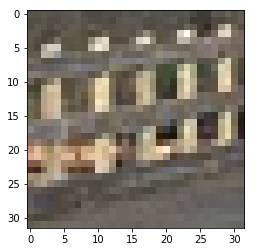

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
np_img = np.asarray(loadedPILImg).astype('uint8')
plt.imshow(np_img[120:152,140:172,:])
#Yoffset = tf.one_hot([[[0]]],64,tf.cast(32.,tf.as_dtype('float64')),tf.cast(0.,tf.as_dtype('float64')))
#print(np.amax(np_img))
#print(np.amin(np_img))
#np_img_float = np_img.astype('float64')/255.
#tf_img_float = tf.expand_dims(np_img_float,axis=0)
#yuv_img = jrf.RGB2YUV(dtype=tf.as_dtype('float64'))(tf_img_float)
#rgb_img = jrf.YUV2RGB(dtype=tf.as_dtype('float64'))(smooth_jpeg2.Wt(smooth_jpeg2.W(yuv_img)))
#np_img = np.asarray(255.*tf.squeeze(rgb_img,axis=0)).astype('uint8')
#plt.imshow(np_img)
#quantized_img = jrf.threeChannelQuantize(smooth_jpeg2.W(yuv_img),qY,qUV,Yoffset)
#rgb_img = jrf.YUV2RGB(dtype=tf.as_dtype('float64'))(smooth_jpeg2.Wt(quantized_img))
#np_img = np.asarray(255.*tf.squeeze(rgb_img,axis=0)).astype('uint8')
#plt.imshow(np_img)
#quantized_yuv_img = smooth_jpeg2.Wt(quantized_img)
#plt.imshow(yuv2rgb(quantized_yuv_img))
#quantized_img = jrf.threeChannelQuantize(smooth_jpeg2.W(tf.expand_dims(jrf.RGB2YUV()(np.asarray(loadedPILImg).astype('float64')),axis=0)),qY,qUV,Yoffset)
#plt.imshow(np.asarray(jrf.YUV2RGB()(tf.squeeze(smooth_jpeg2.Wt(quantized_img),axis=0))).astype('uint8'))

(480, 320, 3)
255
0


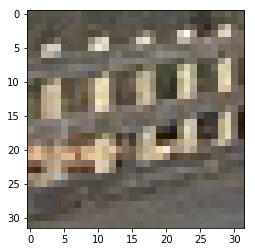

In [8]:
#ci = yuv2rgb(compressedImg)
ci = clip(compressedImg)
plt.imshow(ci[120:152,140:172,:])
print(ci.shape)
print(np.amax(ci))
print(np.amin(ci))

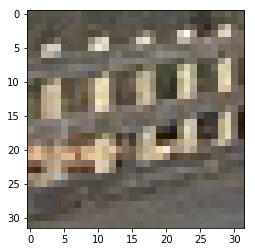

In [9]:
#lp = yuv2rgb(lowpass)
lp = clip(lowpass)
plt.imshow(lp[120:152,140:172,:])

In [10]:
#my_raw = jrf.RGB2YUV(dtype='float64')(tf.expand_dims(tf.cast(yuv2rgb(tf.expand_dims(loadedImg,axis=0)),'float64')/255,axis=0))
my_raw = tf.expand_dims(tf.cast(clip(tf.expand_dims(loadedImg,axis=0)),'float64')/255,axis=0)
#my_lp = jrf.RGB2YUV(dtype='float64')(tf.expand_dims(tf.cast(yuv2rgb(lowpass),'float64')/255,axis=0))
my_lp = tf.expand_dims(tf.cast(clip(lowpass),'float64')/255,axis=0)
my_cmprss = tf.expand_dims(tf.cast(clip(compressedImg),'float64')/255,axis=0)
#my_cmprss = jrf.RGB2YUV(dtype='float64')(tf.expand_dims(tf.cast(yuv2rgb(compressedImg),'float64')/255,axis=0))
print(tf.reduce_mean(tf.keras.losses.mean_squared_error(my_raw,my_lp)))
print(tf.reduce_mean(tf.keras.losses.mean_squared_error(my_raw,my_cmprss)))


tf.Tensor(3.8167978929044254e-05, shape=(), dtype=float64)
tf.Tensor(3.8167978929044254e-05, shape=(), dtype=float64)


In [26]:
import tensorflow as tf
import jpeg_related_functions as jrf
from PIL import Image

In [2]:
import numpy as np
qY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])
qY = qY.astype('float64')/255.
qUV = qY

In [3]:

lmbda = 4.
rho = 0.1
alpha = 1.
noi = 10
image = Image.open("20190728_matthewdruincom_SLE_0033.jpg")
s = np.asarray(image).astype('float64')/255.
s = s[slice(0,1600),slice(0,2800),slice(None)]
s = np.reshape(s,(1,) + s.shape)
fftSz = s.shape[1:3]
smooth_jpeg = jrf.Smooth_JPEG(rho,alpha,noi,qY,qUV,lmbda,fftSz,dtype=tf.float64)
#y,u,By,negC = smooth_jpeg.init_vars(s)
#outputs = smooth_jpeg(s)


In [4]:
outputs = smooth_jpeg(s)

In [5]:
highpass,lowpass = outputs

In [5]:
x,y,u = outputs

In [6]:
print(tf.math.reduce_max(x))
print(tf.math.reduce_max(y))
print(tf.math.reduce_min(x))
print(tf.math.reduce_min(y))
print(tf.math.reduce_mean(x))
print(tf.math.reduce_mean(y))

tf.Tensor(2.039646333059423, shape=(), dtype=float64)
tf.Tensor(2.1151680018556487, shape=(), dtype=float64)
tf.Tensor(0.8840874549355658, shape=(), dtype=float64)
tf.Tensor(0.8297288644681492, shape=(), dtype=float64)
tf.Tensor(1.3342601848054017, shape=(), dtype=float64)
tf.Tensor(1.3342601848058462, shape=(), dtype=float64)


In [4]:
y_init,u_init,By_init,negC,itstats = smooth_jpeg.init_vars(s)

In [5]:
print(tf.reduce_max(y_init))
print(tf.reduce_min(y_init))
print(tf.reduce_mean(y_init))

tf.Tensor(1.1837382249200323, shape=(), dtype=float64)
tf.Tensor(-0.21214950634511898, shape=(), dtype=float64)
tf.Tensor(0.3588879588149992, shape=(), dtype=float64)


In [6]:
print(tf.reduce_max(smooth_jpeg.Wt(negC)))
print(tf.reduce_min(smooth_jpeg.Wt(negC)))
print(tf.reduce_mean(smooth_jpeg.Wt(negC)))

tf.Tensor(1.1837382249200323, shape=(), dtype=float64)
tf.Tensor(-0.21214950634511898, shape=(), dtype=float64)
tf.Tensor(0.3588879588149992, shape=(), dtype=float64)


In [7]:
print(tf.reduce_max(smooth_jpeg.Wt(By_init)))
print(tf.reduce_min(smooth_jpeg.Wt(By_init)))
print(tf.reduce_mean(smooth_jpeg.Wt(By_init)))

tf.Tensor(1.1837382249200323, shape=(), dtype=float64)
tf.Tensor(-0.21214950634511898, shape=(), dtype=float64)
tf.Tensor(0.3588879588149992, shape=(), dtype=float64)


In [8]:
x,Ax = smooth_jpeg.xstep(y_init,u_init,By_init)

In [49]:
print(tf.reduce_max(x))
print(tf.reduce_min(x))
print(tf.reduce_mean(x))

tf.Tensor(1.0390829950833103, shape=(), dtype=float64)
tf.Tensor(-0.03794457125802076, shape=(), dtype=float64)
tf.Tensor(0.3596462283896552, shape=(), dtype=float64)


In [10]:
AxplusC = smooth_jpeg.relax(Ax,By_init,negC)

In [11]:
print(tf.reduce_max(AxplusC[0] + negC[0]))
print(tf.reduce_min(AxplusC[0] + negC[0]))
print(tf.reduce_max(AxplusC[1] + negC[1]))
print(tf.reduce_min(AxplusC[1] + negC[1]))

tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)


In [12]:
y,By = smooth_jpeg.ystep(x,u_init,AxplusC)

In [50]:
print(tf.reduce_max(y))
print(tf.reduce_max(smooth_jpeg.Wt(By)))
print(tf.reduce_min(y))
print(tf.reduce_min(smooth_jpeg.Wt(By)))
print(tf.reduce_mean(y))
print(tf.reduce_mean(smooth_jpeg.Wt(By)))

tf.Tensor(1.095376683391678, shape=(), dtype=float64)
tf.Tensor(1.1340443007804173, shape=(), dtype=float64)
tf.Tensor(-0.07691133243708641, shape=(), dtype=float64)
tf.Tensor(-0.11176080134176089, shape=(), dtype=float64)
tf.Tensor(0.3598486538373756, shape=(), dtype=float64)
tf.Tensor(0.3601107598790794, shape=(), dtype=float64)


In [14]:
u = smooth_jpeg.ustep(u_init,AxplusC,By)

In [45]:
x,Ax = smooth_jpeg.xstep(y,u,By)

In [46]:
AxplusC = smooth_jpeg.relax(Ax,By,negC)

In [47]:
y,By = smooth_jpeg.ystep(x,u,AxplusC)

In [48]:
u = smooth_jpeg.ustep(u,AxplusC,By)

In [11]:
x,Ax = smooth_jpeg.xstep(s,u_init,By_init)

In [15]:
import transforms as transf
fft = transf.fft2d_multichannel(s.shape[1:3])
ifft = transf.ifft2d_multichannel(s.shape[1:3])
s_still = ifft(fft(s))
print(s.shape)
print(s_still.shape)

print(tf.reduce_max(s))
print(tf.reduce_max(s_still))
print(tf.reduce_min(s))
print(tf.reduce_min(s_still))
print(tf.reduce_mean(s))
print(tf.reduce_mean(s_still))

(1, 1600, 2800, 3)
(1, 1600, 2800, 3)
tf.Tensor(1.0, shape=(), dtype=float64)
tf.Tensor(1.0000000000006473, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(-4.956660487039716e-13, shape=(), dtype=float64)
tf.Tensor(0.3588261461251168, shape=(), dtype=float64)
tf.Tensor(0.3588261461249889, shape=(), dtype=float64)


In [6]:
x_new = tf.where(x < 0,0.,x)
x_new = tf.where(x_new > 1.0,1.0,x_new)
smoothImage = Image.fromarray((255.*np.asarray(tf.reshape(x_new,x_new.shape[1:]))).astype('uint8'),'RGB')
smoothImage.show()

In [9]:
y_new = tf.where(highpass < 0.,0.,highpass)
y_new = tf.where(y_new > 1.0,1.0,y_new)
smoothImage = Image.fromarray((255.*np.asarray(tf.reshape(y_new,y_new.shape[1:]))).astype('uint8'),'RGB')
smoothImage.show()

In [8]:
len(lowpass)

3

In [4]:
wtBy_yuv = tf.image.rgb_to_yuv(wtBy)
wtBY_y,wtBY_u,wtBY_v = tf.split(wtBy_yuv,axis=3,num_or_size_splits=3)

wtqwy = smooth_jpeg.Wt([smooth_jpeg.q*tf.math.round(smooth_jpeg.W(y)[channel]/smooth_jpeg.q) for channel in range(3)])
wtqwy_yuv = tf.image.rgb_to_yuv(wtqwy)
wtqwy_y,wtqwy_u,wtqwy_v = tf.split(wtqwy_yuv,axis=3,num_or_size_splits=3)

print(tf.math.reduce_max(wtBY_y))
print(tf.math.reduce_max(wtqwy_y))
print(tf.math.reduce_max(wtBY_u))
print(tf.math.reduce_max(wtqwy_u))
print(tf.math.reduce_max(wtBY_v))
print(tf.math.reduce_max(wtBY_v))
print(tf.math.reduce_min(wtBY_y))
print(tf.math.reduce_min(wtqwy_y))
print(tf.math.reduce_min(wtBY_u))
print(tf.math.reduce_min(wtqwy_u))
print(tf.math.reduce_min(wtBY_v))
print(tf.math.reduce_min(wtBY_v))
print(tf.math.reduce_mean(wtBY_y))
print(tf.math.reduce_mean(wtqwy_y))
print(tf.math.reduce_mean(wtBY_u))
print(tf.math.reduce_mean(wtqwy_u))
print(tf.math.reduce_mean(wtBY_v))
print(tf.math.reduce_mean(wtBY_v))


tf.Tensor(0.2570130949512816, shape=(), dtype=float64)
tf.Tensor(0.2570130949512816, shape=(), dtype=float64)
tf.Tensor(0.04323715026838358, shape=(), dtype=float64)
tf.Tensor(0.04323715026838358, shape=(), dtype=float64)
tf.Tensor(0.07887996586296282, shape=(), dtype=float64)
tf.Tensor(0.07887996586296282, shape=(), dtype=float64)
tf.Tensor(-0.03274309150125233, shape=(), dtype=float64)
tf.Tensor(-0.03274309150125233, shape=(), dtype=float64)
tf.Tensor(-0.033754955995817404, shape=(), dtype=float64)
tf.Tensor(-0.033754955995817404, shape=(), dtype=float64)
tf.Tensor(-0.05825989553795034, shape=(), dtype=float64)
tf.Tensor(-0.05825989553795034, shape=(), dtype=float64)
tf.Tensor(0.06513041623543925, shape=(), dtype=float64)
tf.Tensor(0.06513041623543925, shape=(), dtype=float64)
tf.Tensor(-0.0011787114132774982, shape=(), dtype=float64)
tf.Tensor(-0.0011787114132774982, shape=(), dtype=float64)
tf.Tensor(0.007870027512006482, shape=(), dtype=float64)
tf.Tensor(0.007870027512006482, sha

In [4]:
len(lowpass)

1

In [4]:
x = tf.cast(lowpass,tf.float32)
x_small = x[slice(None),slice(0,256),slice(0,256),slice(None)]
smoothImage = Image.fromarray(np.asarray(tf.reshape(x_small,x_small.shape[1:])),'RGB')
smoothImage.show()

In [5]:
tf.reduce_max(x_small)

<tf.Tensor: shape=(), dtype=float32, numpy=0.92229486>

In [6]:
tf.reduce_min(x_small)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8896151>

In [7]:
tf.reduce_max(s)

<tf.Tensor: shape=(), dtype=float64, numpy=1.0>

In [8]:
tf.reduce_min(s)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [9]:
x_new,Ax_new = smooth_jpeg.xstep(s)

In [10]:
tf.reduce_max(x_new)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9259259259265392>

In [11]:
tf.reduce_min(x_new)

<tf.Tensor: shape=(), dtype=float64, numpy=-4.566629576338341e-13>

In [4]:
lowpass = y

In [6]:
lowpass = wtBy

In [4]:
x_new = tf.where(lowpass < 0,0.,lowpass)
x_new = tf.where(x_new > 1.0,1.0,x_new)
smoothImage = Image.fromarray((255.*np.asarray(tf.reshape(x_new,x_new.shape[1:]))).astype('uint8'),'RGB')
smoothImage.show()

In [4]:
print(tf.reduce_max(lowpass))
print(tf.reduce_min(lowpass))
print(tf.reduce_mean(lowpass))

tf.Tensor(0.025259007677445326, shape=(), dtype=float64)
tf.Tensor(-0.004116784037421037, shape=(), dtype=float64)
tf.Tensor(0.007235759263040731, shape=(), dtype=float64)


In [5]:
tf.reduce_min(y)

<tf.Tensor: shape=(), dtype=float64, numpy=0.5130693627046149>

In [6]:
tf.reduce_mean(y)

<tf.Tensor: shape=(), dtype=float64, numpy=0.6106675396815834>

In [4]:
tf.reduce_max(wtBy)

<tf.Tensor: shape=(), dtype=float64, numpy=0.7188945327525801>

In [5]:
tf.reduce_min(wtBy)

<tf.Tensor: shape=(), dtype=float64, numpy=0.4095120582383085>

In [6]:
tf.reduce_mean(wtBy)

<tf.Tensor: shape=(), dtype=float64, numpy=0.5205163330596897>

In [6]:
smooth_jpeg.W(wtBy)[0].shape

TensorShape([1, 200, 350, 64])

In [10]:
tf.reduce_mean(smooth_jpeg.Wt([smooth_jpeg.q*tf.math.round(smooth_jpeg.W(y)[channel]/smooth_jpeg.q) for channel in range(3)]))

<tf.Tensor: shape=(), dtype=float64, numpy=0.613012462000272>

In [5]:
tf.reduce_max(x_new)

<tf.Tensor: shape=(), dtype=float64, numpy=0.09169928799980395>

In [6]:
tf.reduce_min(x_new)

<tf.Tensor: shape=(), dtype=float64, numpy=0.05429964236971775>

In [16]:
x_new.shape

TensorShape([1, 1600, 2800, 3])

In [ ]:
smoothImage = Image.fromarray(np.asarray(tf.reshape(x_new,x_new.shape[1:]))*255)

In [3]:
from PIL import Image
image = Image.open("20190728_matthewdruincom_SLE_0033.jpg")
#image = Image.open("20200202_matthewdruincom_SLW_0085.jpg")
#image.show()
import numpy as np
x_orig = np.asarray(image).astype('float64')

x_batch = np.reshape(x_orig.astype('float64')/255.,(1,)+x_orig.shape)
x_batch = x_batch[slice(None),slice(0,1600),slice(0,2800),slice(None)]
x = (np.reshape(x_batch,x_batch.shape[1:])*255.).astype('uint8')
x_orig = Image.fromarray(x)
x_cmprss = tf.image.adjust_jpeg_quality(x,25)
image_cmprss = Image.fromarray(np.asarray(x_cmprss),'RGB')
image_cmprss.show()
x_cmprss_batch = np.reshape(np.asarray(x_cmprss).astype('float64')/255.,(1,)+x_cmprss.shape)
#x_cmprss_apprx = jrf.Linear_JPEG_Compression_Approx(x_cmprss_batch)(x_batch)
#image_cmprss_apprx = Image.fromarray(np.asarray(x_cmprss_apprx*255).astype('uint8'),'RGB')
#image_cmprss_apprx.show

#y = jpeg_coef2rgb(rgb2jpeg_coef(x))
#z = jpeg_coef2rgb(rgb2jpeg_coef(x))

In [4]:
print(x_batch.shape)
print(x_cmprss_batch.shape)

(1, 1600, 2800, 3)
(1, 1600, 2800, 3)


In [4]:
x_cmprss_apprx = jrf.Linear_JPEG_Compression_Approx(x_cmprss_batch,epsilon=1e-3)(x_batch)
#print(tf.math.reduce_min(tf.where(jrf.Linear_JPEG_Compression_Approx(x_cmprss_batch).masky,1.0,0.0)))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [5]:
image_cmprss_apprx = Image.fromarray(np.asarray(tf.reshape(x_cmprss_apprx,x_cmprss_apprx.shape[1:])*255).astype('uint8'),'RGB')
image_cmprss_apprx.show()

In [6]:
print(tf.math.reduce_max(x_cmprss_apprx))

tf.Tensor(1.0698118, shape=(), dtype=float32)


In [7]:
tf.math.reduce_min(y)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [4]:
print(tf.math.reduce_max(tf.math.abs(x - y)))
print(tf.math.reduce_max(tf.math.abs(z - y)))

tf.Tensor(0.21713108, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [5]:
x.shape

TensorShape([5, 128, 128, 3])

In [5]:
x[0,0,0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.22571766>

In [6]:
y[0,0,0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.4955484>

In [7]:
x = tf.one_hot(indices=[[[0]]],depth=64,on_value=2.,dtype=tf.float64)

In [8]:
x.shape

TensorShape([1, 1, 1, 64])

In [9]:
x[0,0,0,0]

<tf.Tensor: shape=(), dtype=float64, numpy=2.0>